In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
%matplotlib inline

In [2]:
sns.set_style('whitegrid')

In [3]:
def print_head(f, size=1):
    with open(f) as read_file:
        print([next(read_file) for _ in range(size)])

In [4]:
print_head('review.json')

['{"review_id":"VfBHSwC5Vz_pbFluy07i9Q","user_id":"cjpdDjZyprfyDG3RlkVG3w","business_id":"uYHaNptLzDLoV_JZ_MuzUA","stars":5,"date":"2016-07-12","text":"My girlfriend and I stayed here for 3 nights and loved it. The location of this hotel and very decent price makes this an amazing deal. When you walk out the front door Scott Monument and Princes street are right in front of you, Edinburgh Castle and the Royal Mile is a 2 minute walk via a close right around the corner, and there are so many hidden gems nearby including Calton Hill and the newly opened Arches that made this location incredible.\\n\\nThe hotel itself was also very nice with a reasonably priced bar, very considerate staff, and small but comfortable rooms with excellent bathrooms and showers. Only two minor complaints are no telephones in room for room service (not a huge deal for us) and no AC in the room, but they have huge windows which can be fully opened. The staff were incredible though, letting us borrow umbrellas f

In [5]:
print_head('business.json')

['{"business_id": "YDf95gJZaq05wvo7hTQbbQ", "name": "Richmond Town Square", "neighborhood": "", "address": "691 Richmond Rd", "city": "Richmond Heights", "state": "OH", "postal_code": "44143", "latitude": 41.5417162, "longitude": -81.4931165, "stars": 2.0, "review_count": 17, "is_open": 1, "attributes": {"RestaurantsPriceRange2": 2, "BusinessParking": {"garage": false, "street": false, "validated": false, "lot": true, "valet": false}, "BikeParking": true, "WheelchairAccessible": true}, "categories": ["Shopping", "Shopping Centers"], "hours": {"Monday": "10:00-21:00", "Tuesday": "10:00-21:00", "Friday": "10:00-21:00", "Wednesday": "10:00-21:00", "Thursday": "10:00-21:00", "Sunday": "11:00-18:00", "Saturday": "10:00-21:00"}}\n']


In [6]:
def get_file_size(f):
    line_count = 0
    with open(f, 'r') as read_file:
        for _ in read_file:
            line_count += 1
    return line_count

In [7]:
print('Total number of businesses:', get_file_size('business.json'))
print('Total number of reviews', get_file_size('review.json'))

Total number of businesses: 156639
Total number of reviews 4736897


## Load Data 

In [8]:
def extract_data(f):
    with open(f, 'r') as read_file:
        for _ in read_file:
            yield _

## Business Data 

### Cities and States 

In [9]:
def make_count_df(f, key, columns):
    data = extract_data(f)
    counts = Counter([json.loads(x).get(key).lower().strip() for x in data])
    return pd.DataFrame(list(counts.items()), columns=columns)

In [10]:
replacement_dict = {
    'st': 'saint', 
    'st.': 'saint', 
    'hts.': 'heights', 
    'hts': 'heights',
    'hghts': 'heights',
    'ahwahtukee': 'ahwatukee',
    'twp': 'township',
    "baie-d'urfe": "baie-d'urfé",
    'bellvue': 'bellevue',
    'c las vegas': 'las vegas',
    'caledon east': 'caledon',
    'central city': 'central city village',
    'chander': 'chandler',
    'charlote': 'charlotte',
    'charlotte (university)': 'charlotte',
    'chatauguay': 'châteauguay',
    'chateauguay': 'châteauguay',
    'concord township': 'concord',
    'côte-saint-luc': 'côte saint-luc',
    'cote-saint-luc': 'côte saint-luc',
    'cote saint-luc': 'côte saint-luc',
    'fls': 'falls',
    'deforest': 'de forest',
    'dollard-des-ormeaux': 'dollard-des ormeaux',
    'east gwilimbury': 'east gwillimbury',
    'east mc keesport': 'east mckeesport',
    'edimbourg': 'edinburgh',
    'edinburgh city of': 'edinburgh',
    'esslingen': 'esslingen am neckar',
    'fitchburgh': 'fitchburg',
    'fort  mill': 'fort mill',
    'ft.': 'fort',
    'gilbert az': 'gilbert',
    'glbert': 'gilbert',
    'glendale az': 'glendale',
    'goodyear az': 'goodyear',
    'harrisburg,': 'harrisburg',
    'harrisbug': 'harrisburg',
    'henderson (green valley)': 'henderson',
    'henderson and las vegas': 'henderson',
    'henderson nevada': 'henderson',
    'henderston': 'henderson',
    'hendserson':' henderson',
    'indian land,': 'indian land',
    'indian lands': 'indian land',
    'kernen im remstal': 'kernen',
    'kernen-stetten': 'kernen',
    'king': 'king city', 
    'las  vegas': 'las vegas',
    'las vegas east': 'las vegas',
    'las vegas nv': 'las vegas',
    'las vegas strip': 'las vegas',
    'las vegas, nv': 'las vegas',
    'las vegass': 'las vegas', 
    'lasvegas': 'las vegas', 
    'laveen village': 'laveen',
    'leinfelden-echterdingen': 'leinfelden-echterdingen',
    'litchfield': 'litchfield park', 
    'mathews': 'matthews',
    'mattews': 'matthews',
    'mayfield heights (cleveland)': 'mayfield heights',
    'mayfield heights.': 'mayfield heights',
    'mayfield village': 'mayfield',
    'mccandless township': 'mccandless',
    'mcmurry': 'mcmurray',
    'median': 'medina',
    'mentor on the': 'mentor',
    'mentor on the lake': 'mentor',
    'mentor-on-the-lake': 'mentor',
    'mesa arizona': 'mesa',
    'mesa az': 'mesa',
    'meza': 'mesa',
    'mint  hill': 'mint hill',
    'missisauga': 'mississauga',
    'mississauaga': 'mississauga',
    'mississuaga': 'mississauga',
    'monoroeville': 'monroeville',
    'monreoville': 'monroeville',
    'monroeville - pit.': 'monroeville',
    'montral': 'montréal',
    'montreal-nord': 'montréal',
    'montreal': 'montréal',
    'montreal-ouest': 'montréal',
    'montreal-west': 'montréal',
    'montréal (québec)': 'montréal',
    'montréal-nord': 'montréal',
    'montréal-ouest': 'montréal',
    'montéal': 'montréal',
    'moon township': 'moon',
    'mt': 'mount',
    'mt.': 'mount',
    'municipalilty of murrysville': 'murrysville',
    'murrysville (monroeville)': 'murrysville',
    'n e las vegas': 'las vegas',
    'n las vegas': 'las vegas',
    'n w las vegas': 'las vegas',
    'n. las vegas': 'las vegas', 
    'n. olmsted': 'olmsted',
    'n. randall': 'randall',
    'n. ridgeville': 'ridgeville',
    'nellis': 'nellis air force base',
    'nellis afb': 'nellis air force base',
    'north huntington': 'north huntingdon', 
    'north las vegas': 'las vegas',
    'north olmstead': 'olmstead',
    'north olmsted': 'olmstead',
    'north olmsted,': 'olmstead',
    'north scottsdale': 'scottsdale',
    "peoria ave citizen's group": 'peoria',
    'pheonix': 'phoenix',
    'phoenix az': 'phoenix',
    'phoenix metro area': 'phoenix',
    'phoenix': 'phoenix',
    'phoenix, az': 'phoenix',
    'phoneix': 'phoenix',
    'phoneix, az': 'phoenix',
    'phoniex': 'phoenix',
    'phx': 'phoenix',
    'pittsburch': 'pittsburgh',
    'pittsburg': 'pittsburgh',
    'pointe claire': 'pointe-claire',
    'point claire': 'pointe-claire',
    'richmond hil': 'richmond hill',
    'robinson': 'robinson township',
    'robinson town': 'robinson township',
    'rosemere': 'rosemère',
    'ross': 'ross township',
    'russell': 'russell township',
    'saint bruno': 'saint-bruno-de-montarville',
    'sainte-thérèse-de-blainville': 'sainte-thérèse',
    'sainte-therese': 'sainte-thérèse',
    'scarborough,': 'scarborough',
    'scaroborough': 'scarborough',
    'scarobrough': 'scarborough',
    'schottsdale': 'scottsdale',
    'scotesdale': 'scottsdale',
    'scottdale': 'scottsdale',
    'scottsdale az': 'scottsdale',
    'shady side': 'shadyside',
    'sindelfingen': 'sindelfingen/eichholz',
    'shaler township': 'shaler',
    'south las vegas': 'las vegas',
    'south park township': 'south park',
    'sun city anthem': 'sun city',
    'sun city grand': 'sun city',
    'sun city west': 'sun city',
    'surprise crossing': 'surprise',
    'tempe arizona': 'tempe',
    'thornihil': 'thornhill',
    'toronto, ontario': 'toronto',
    'totronto': 'toronto',
    'st': 'saint',
    'st.': 'saint',
    'vaudreuil': 'vaudreuil-dorion',
    'vaughn': 'vaughan',
    'vaughn city': 'vaughan', 
    'w henderson': 'henderson',
    'w spring valley': 'spring valley',
    'warrensville': 'warrensville heights',
    'westworld scottsdale': 'scottsdale',
    'willoughby hills': 'willoughby',
    'woodbridge (vaughan)': 'woodbridge',
    'woodmere village': 'woodmere',
    'york regional municipality': 'york',
    'île des soeurs': 'île-des-soeurs'
}

In [11]:
city_counts = make_count_df('business.json', 'city', columns=['City', 'Business Count'])
state_counts = make_count_df('business.json', 'state', columns=['State', 'Business Count'])

In [12]:
cities = [(json.loads(x).get('city').lower().strip(), json.loads(x).get('state').lower().strip()) 
          for x in extract_data('business.json')]
df = pd.DataFrame(cities, columns=['City', 'State'])

In [13]:
df['City'] = df['City'].map(lambda x: replacement_dict.get(x) if replacement_dict.get(x) else x)

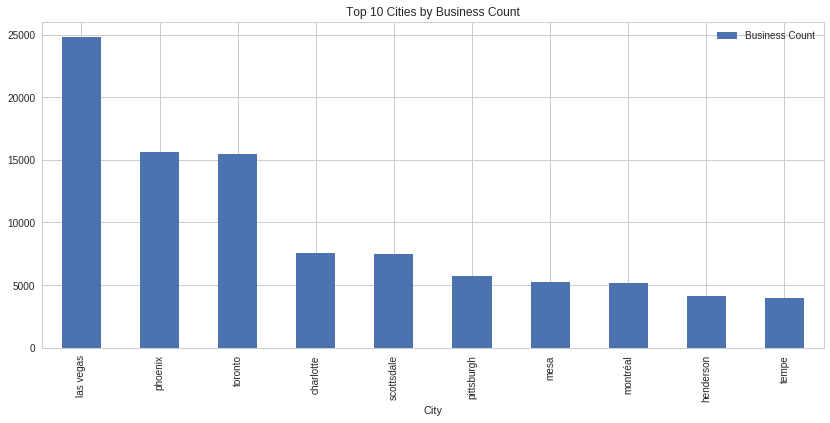

In [14]:
top_10_cities = city_counts.sort_values(by='Business Count', ascending=False).iloc[:10]
top_10_cities.plot.bar('City', 'Business Count', figsize=(14, 6))
plt.title('Top 10 Cities by Business Count');

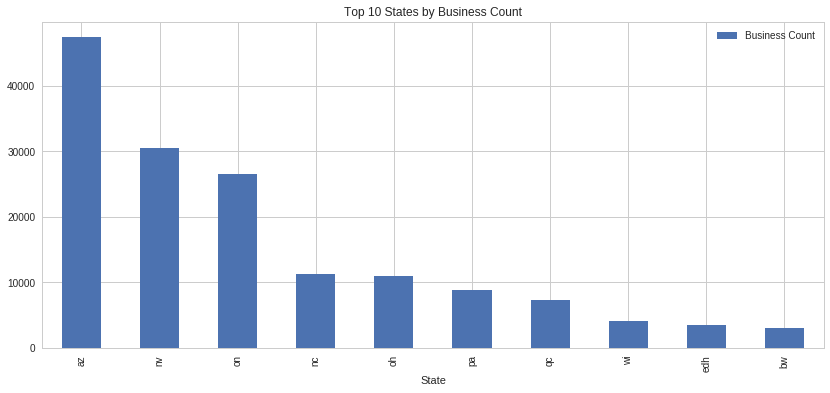

In [15]:
top_10_states = state_counts.sort_values(by='Business Count', ascending=False).iloc[:10]
top_10_states.plot.bar('State', 'Business Count', figsize=(14, 6))
plt.title('Top 10 States by Business Count');

### Star Ratings

In [16]:
review_counts = Counter([json.loads(x).get('stars') for x in extract_data('business.json')])

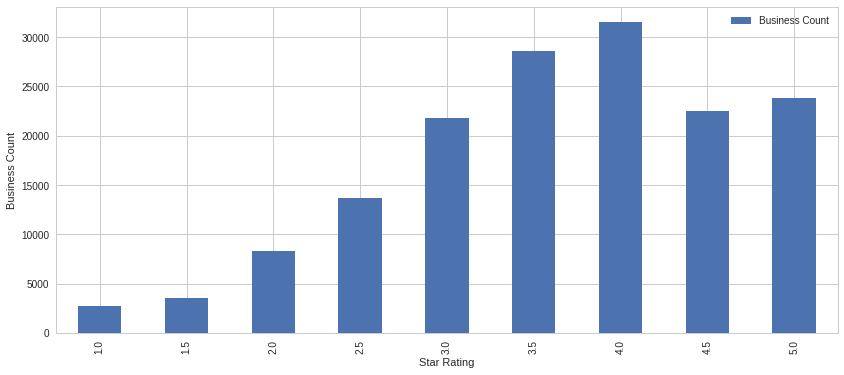

In [17]:
pd.DataFrame(list(review_counts.items()), columns=['Star Rating', 'Business Count'])\
    .sort_values(by='Star Rating')\
    .plot.bar('Star Rating', 'Business Count', figsize=(14, 6))
plt.ylabel('Business Count')
plt.title('')

### Business Categories 

In [18]:
categories = pd.DataFrame({'Category': [b.lower().strip() for x in extract_data('business.json') 
              for b in json.loads(x).get('categories')]})

In [19]:
categories.describe()

,Category
count,590290
unique,1240
top,restaurants
freq,51613


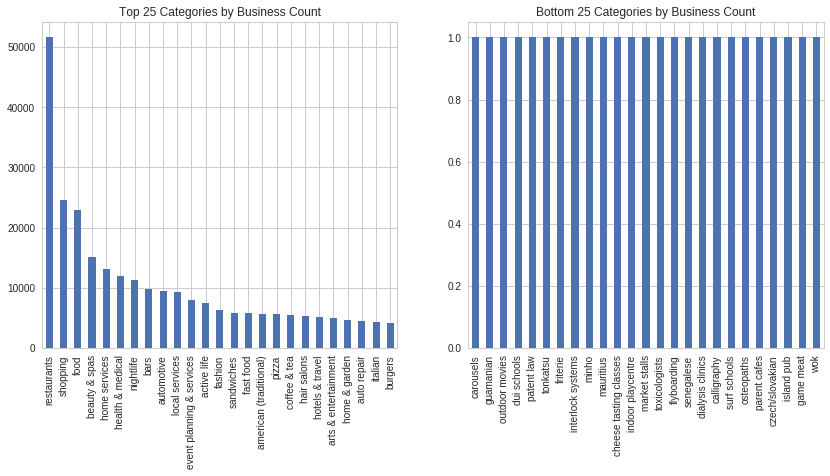

In [20]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
categories['Category'].value_counts()[:25].plot.bar(ax=ax1, title='Top 25 Categories by Business Count')
categories['Category'].value_counts()[::-1][:25].plot.bar(ax=ax2, title='Bottom 25 Categories by Business Count')

### Review Counts 

In [21]:
review_counts = pd.DataFrame({'Review Count': [json.loads(r).get('review_count') for r in extract_data('business.json')]})

In [22]:
review_counts.describe()

,Review Count
count,156639.000000
mean,30.238159
std,96.486631
min,3.000000
25%,4.000000
50%,9.000000
75%,23.000000
max,6979.000000


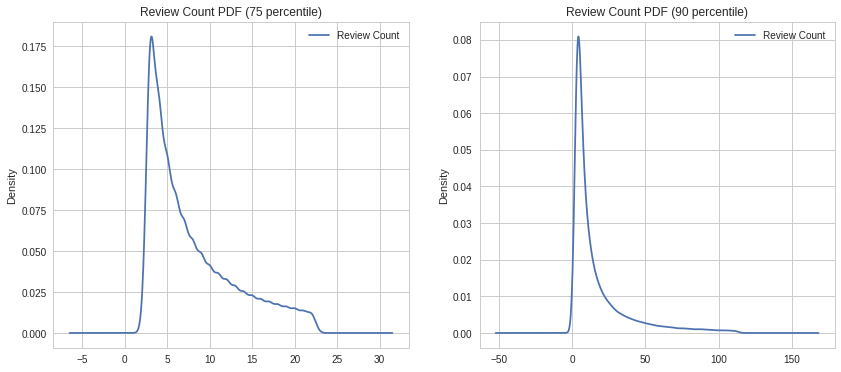

In [23]:
f, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(14, 6))
review_counts[review_counts['Review Count'] < review_counts['Review Count'].quantile(.75)]\
    .plot.density(title='Review Count PDF (75 percentile)', ax=ax1)
review_counts[review_counts['Review Count'] < review_counts['Review Count'].quantile(.95)]\
    .plot.density(title='Review Count PDF (90 percentile)', ax=ax2)